## FFT demo of a real, periodic signal  
a) naive way  
b) windowing with DC treatment  


In [1]:
import io
from nbformat import read

def execute_notebook(nbfile):
    
    with io.open(nbfile) as f:
        nb = read(f,3)
    
    ip = get_ipython()
    
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
        
        
    
execute_notebook("create_plot_signal.ipynb")

from numpy import *
from numpy.fft import fft
from matplotlib.pyplot import *
%matplotlib inline

# redefine default figure size and fonts
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'sans serif',size=16)
mpl.rc('figure',figsize=(12,8))
mpl.rc('lines', linewidth=1, color='lightblue',linestyle=':',marker='o')

## Given periodic signal, sampling frequency and total time

In [2]:
f_s = 100.0 # sampling frequency (Hz)
T = 3.0 # total actual sample time (s)
g = loadtxt('FFT_Example_data_with_window.txt')
# first few values
g[:5]

array([-1.7527, -0.565 ,  0.8801,  3.1924,  1.2804])

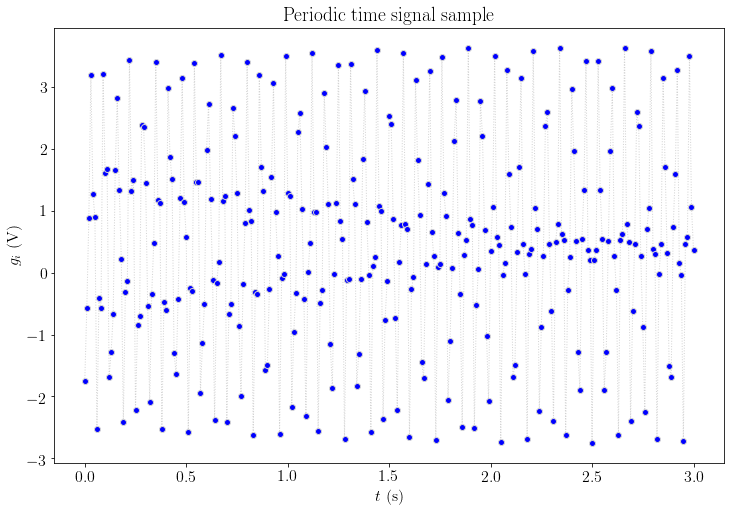

In [3]:
# first, visualize the signal
del_t = 1/f_s   # time resolution [s]
t = arange(0.0,T+del_t,del_t)  # time, t (s)

# plotSignal(t,g,f_s)
plot(t,g,marker='o',markerfacecolor='b',linestyle=':',color='lightgrey')
xlabel('$t$ (s)')
ylabel('$g_i$ (V)')
title('Periodic time signal sample')
show()

In [4]:
# does it have a non-zero mean, DC value
DC = g.mean()
print 'DC = %f [V]' % DC

DC = 0.452950 [V]


### Calculate the necessary parameters: $N, \Delta t, \Delta f, f_{fold},N_{freq}$

In [5]:
N = f_s*T           # number of data points
del_t = 1./f_s      # time resolution (s)
del_f = 1./T        # frequency resolution(Hz)
f_fold = f_s/2.     # folding frequency = Nyquist frequency of FFT (Hz)
N_freq = int(N/2.)  # number of useful frequency points

### Frequency analysis using naive FFT

In [6]:
frequency = arange(0,f_fold,del_f)  #frequency (Hz)
G = fft(g) # FFT 
print G[:10]
print G.shape

[136.3379    +0.j           0.85689194+0.01756347j
   0.7956033 +0.03999151j   0.83065943+0.02317239j
   0.81648114+0.01029308j   0.86012694-0.03048062j
   0.88366205-0.03279026j   0.91944369-0.03388283j
   0.82537342-0.0616697j    0.78619988+0.03823325j]
(301,)


/Users/alex/miniconda3/envs/taas/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


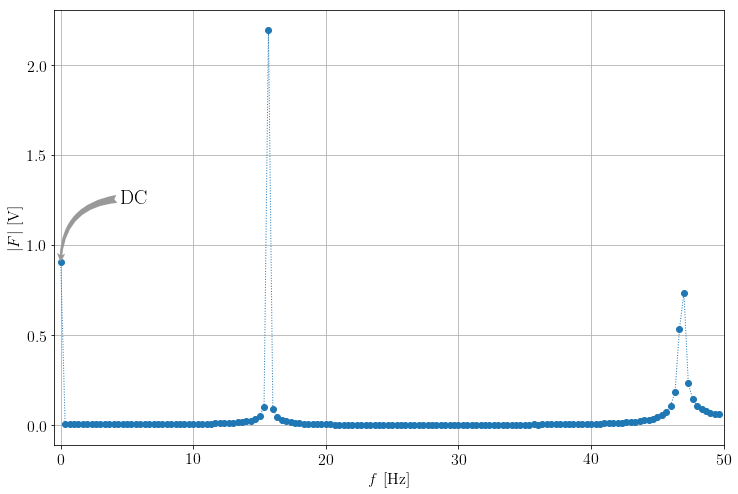

In [7]:
Magnitude = abs(G)/(N_freq)  # complex -> amplitude:  |F|/(N/2)

figure()
plot(frequency,Magnitude[:N_freq])
grid('on')
xlim([-.5,f_fold])
xlabel('$f$ [Hz]')
ylabel('$|F|$ [V]')
annotate('DC', xy=(0,.9), xycoords='data',
                xytext=(60, 60), textcoords='offset points',
                size=20,
                arrowprops=dict(arrowstyle="fancy",
                                fc="0.6", ec="none",
                                connectionstyle="angle3,angleA=0,angleB=90"),
                )
show()

### Notes
1. Note the value at 0 Hz, what can we learn from it (we saw it's about 0.45 Volt? 
2. What do we learn from about the frequencies? about 2.1V at 16 Hz and 0.7 Volt at 47 Hz? 
3. Let's remove DC first and see the result

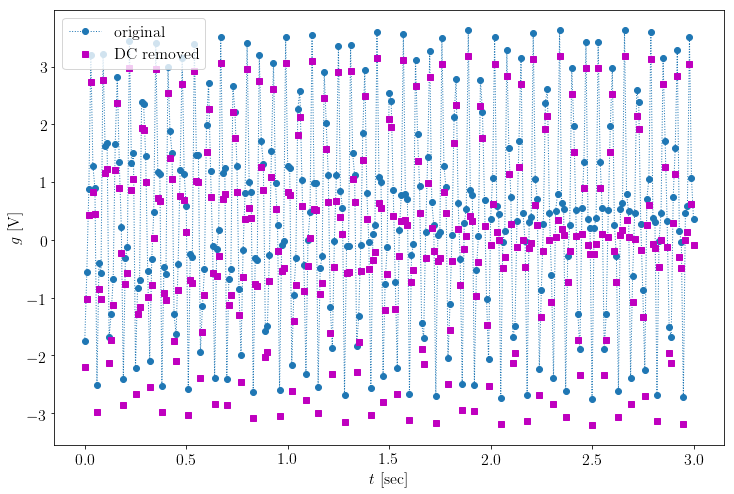

In [8]:
figure()
plot(t,g,t,g-DC,'ms')
xlabel('$t$ [sec]')
ylabel('$g$ [V]')
legend(('original','DC removed'))

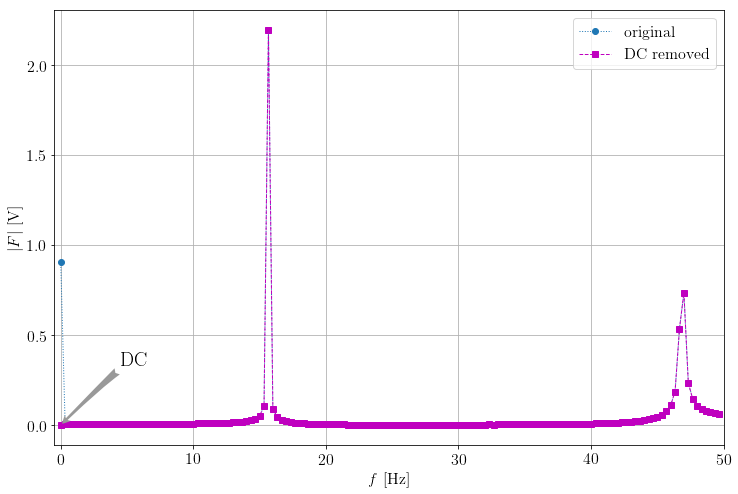

In [9]:
# repeat the frequency analysis
G = fft(g-DC) # FFT of the signal without DC
Magnitude1 = abs(G)/(N_freq)  # complex -> amplitude:  |F|/(N/2)

figure()
plot(frequency,Magnitude[:N_freq], frequency,Magnitude1[:N_freq],'--ms')
annotate('DC', xy=(0,0), xycoords='data',
                xytext=(60, 60), textcoords='offset points',
                size=20,
                arrowprops=dict(arrowstyle="fancy",
                                fc="0.6", ec="none",
                                connectionstyle="angle3,angleA=0,angleB=45"),
                )
grid('on')
xlim([-.5,f_fold])
xlabel('$f$ [Hz]')
ylabel('$|F|$ [V]')
legend(('original','DC removed'))
show()

### Let's use do it the right way:
1. use 2^k number of points for faster FFT
2. multiply the signal by a low-pass filter:
    * assure there is no aliasing
    * get read of the edges and make it less leaking


In [10]:
# let's check how much we gain if we do it right size:
%timeit(fft(g)) 
%timeit(fft(g[:256]))  # 256 points instead of 301, not waisting much data


# even if it's longer, but the right size with zeros at the end
g1 = zeros((512,))
g1[:301] = g.copy()
%timeit(fft(g1))

The slowest run took 7.57 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 41.3 µs per loop
The slowest run took 6.82 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 34.6 µs per loop
The slowest run took 14.84 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 40.6 µs per loop


In [11]:
# let's do it right:
N_2 = 2**fix(log2(N)).astype(int)        # shorten to 2^k
T_2 = N_2/f_s                             #  total useful sample time (s)
del_f_2 = 1/T_2                           # (Hz)
N_freq_2 = N_2/2                         # number of useful discrete frequencies
t_2 = arange(0.0,T_2+del_t,del_t)  #time, t (s)
frequency_2 = arange(0,f_fold,del_f_2)  #frequency (Hz)
len2, = t_2.shape

# remove DC first
g_uncoupled_2 = g - DC

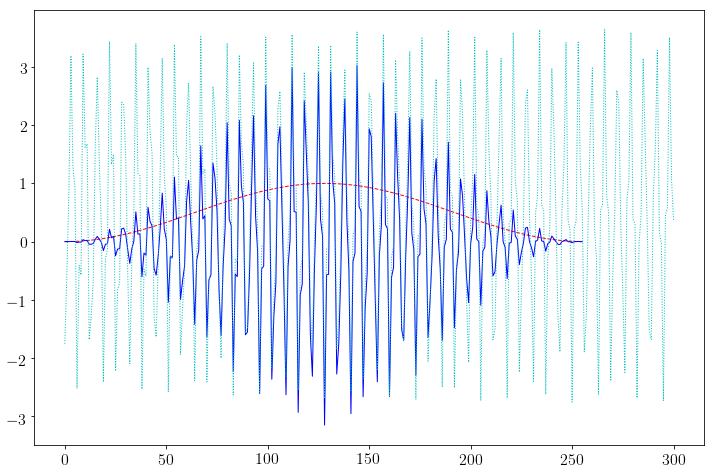

In [12]:
# create the low pass filter, called Hanning
u_Hann_2 = 0.5*(1-cos(2*pi*t_2[:-1]/T_2))  #u_Hanning(t)
DC_2 = mean(g[:len2-1])  #DC = mean value of input signal (V) (average of all the useful data)
g_uncoupled_2 = g[:len2-1]-DC_2  # uncoupled

g_Hann_2 = g_uncoupled_2 * u_Hann_2

figure()
plot(u_Hann_2,'r--')
plot(g_Hann_2,'b-')
plot(g,'c:')

In [13]:
# take the FFT of the filtered, shorter signal
G_Hann_2 = fft(g_Hann_2,N_2)  #G(omega) with Hanning window

Magnitude_Hann_2 = abs(G_Hann_2)*sqrt(8./3.)/(N_2/2)  #|F|*sqrt(8/3)/(N/2)
# Magnitude_Hann_2[0] = Magnitude_Hann_2[0]/2 + DC_2  #(also divide the first one by 2, and add back the DC value)

# len_loc, = Magnitude_Hann_2.shape
# A_2 = Magnitude_Hann_2[0:round(len_loc/2)]
# Freq_2 = frequency_2[0:round(len_loc/2)]

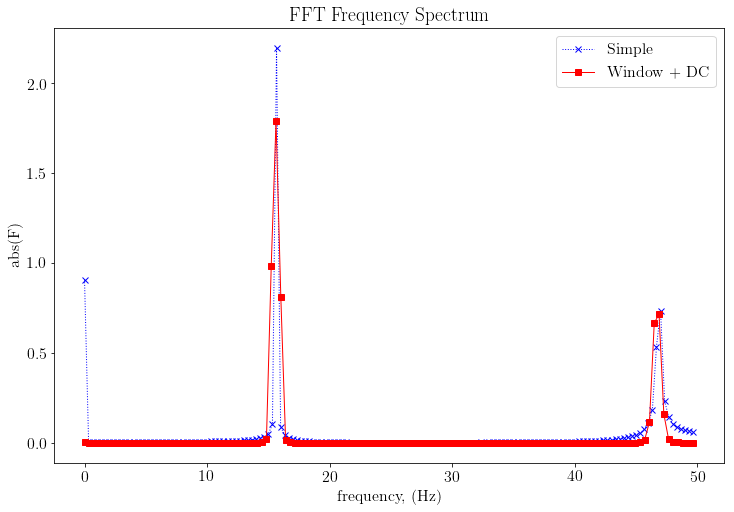

In [14]:

figure()
plot(frequency,Magnitude[:frequency.shape[0]],'b:x')
plot(frequency_2,Magnitude_Hann_2[:frequency_2.shape[0]], 'r-s')
xlabel('frequency, (Hz)')
ylabel('abs(F)')
title('FFT Frequency Spectrum')
legend(('Simple','Window + DC'))

In [15]:
# the frequency resolution is worse, but the result is better
del_f, del_f_2

(0.3333333333333333, 0.390625)

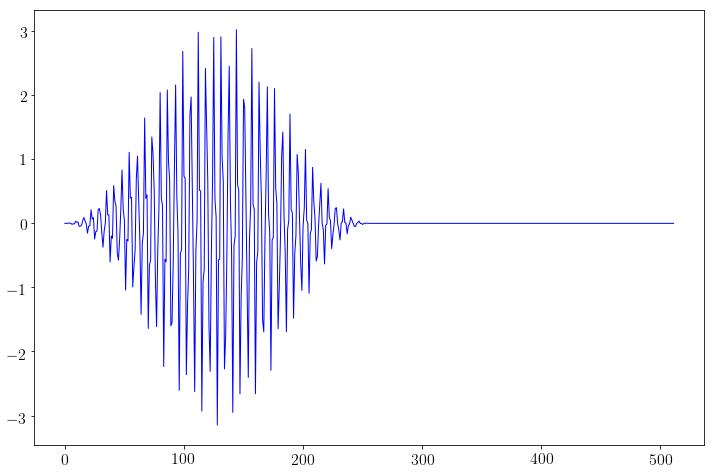

In [16]:
# let's do it better if we get more points, better resolution
# we can recover the same resolution as before by adding zeros
# or improve somewhat by taking longer to the next 2^k vector

N_3 = 2**ceil(log2(N)).astype(int)        # shorten to 2^k
T_3 = N_3/f_s                             #  total useful sample time (s)
del_f_3 = 1/T_3                           # (Hz)
N_freq_3 = int(N_3/2)                         # number of useful discrete frequencies
t_3 = arange(0.0,T_3+del_t,del_t)  #time, t (s)
frequency_3 = arange(0,f_fold,del_f_3)  #frequency (Hz)
len3, = t_3.shape

# prepare the same signal
g_uncoupled_2 = g - DC
u_Hann_2 = 0.5*(1-cos(2*pi*t_2[:-1]/T_2))  #u_Hanning(t)
DC_2 = mean(g[:int(len2-1)])  #DC = mean value of input signal (V) (average of all the useful data)
g_uncoupled_2 = g[:int(len2-1)]-DC_2  # uncoupled
g_Hann_2 = g_uncoupled_2 * u_Hann_2


# pad with zeros
g_Hann_3 = zeros((N_3,))
g_Hann_3[:g_Hann_2.shape[0]] = g_Hann_2.copy() 

figure()
plot(g_Hann_3,'b-')

# take the FFT of the filtered, shorter signal
G_Hann_3 = fft(g_Hann_3,N_3)  #G(omega) with Hanning window

Magnitude_Hann_3 = abs(G_Hann_3)*sqrt(8./3.)/(N_2/2)  #|F|*sqrt(8/3)/(N/2)
# Magnitude_Hann_2[0] = Magnitude_Hann_2[0]/2 + DC_2  #(also divide the first one by 2, and add back the DC value)

len_loc, = Magnitude_Hann_3.shape
A_3 = Magnitude_Hann_3[0:int(len_loc/2)]
Freq_3 = frequency_3[0:int(len_loc/2)]

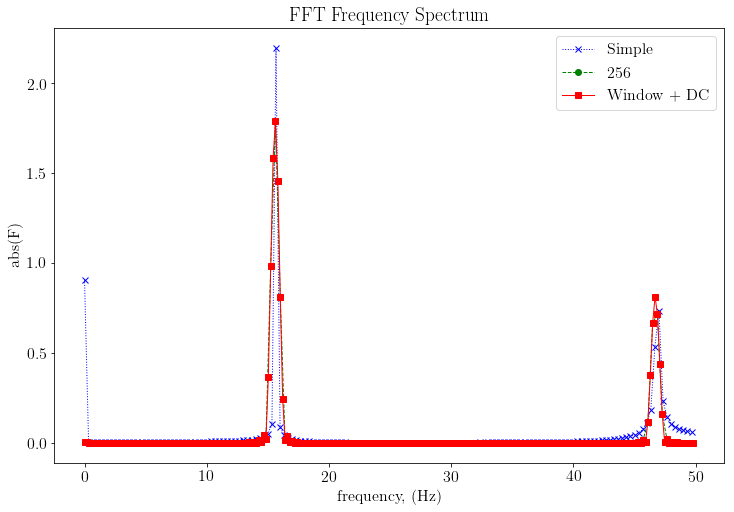

In [17]:
figure()
plot(frequency,Magnitude[:frequency.shape[0]],'b:x')
plot(frequency_2,Magnitude_Hann_2[:frequency_2.shape[0]], 'g--o')
xlabel('frequency, (Hz)')
plot(frequency_3,Magnitude_Hann_3[:frequency_3.shape[0]], 'r-s')
xlabel('frequency, (Hz)')
ylabel('abs(F)')
title('FFT Frequency Spectrum')
legend(('Simple','256', 'Window + DC'))

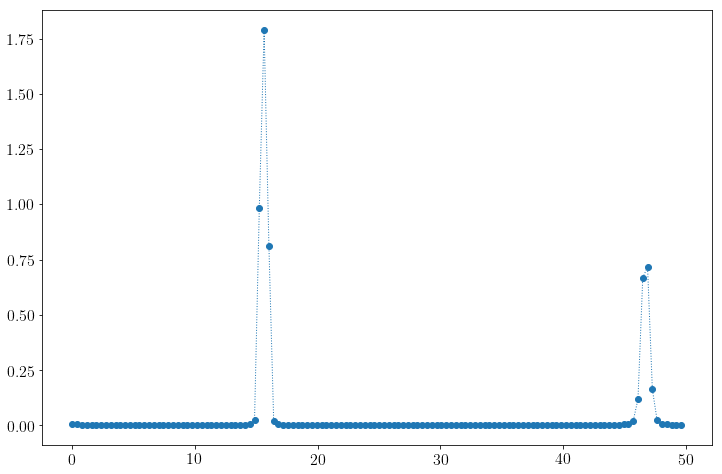

In [18]:
f = frequency_2
a = Magnitude_Hann_2[:f.shape[0]]
plot(f,a)

In [19]:
a1,f1 = a.max(),f[a.argmax()]
print a1,f1

1.7914015486916908 15.625


In [20]:
b = a.copy()
b[:a.argmax()+10] = 0 # remove the first peak
a2,f2 = b.max(),f[b.argmax()]
print a2,f2

0.7161739235195176 46.875


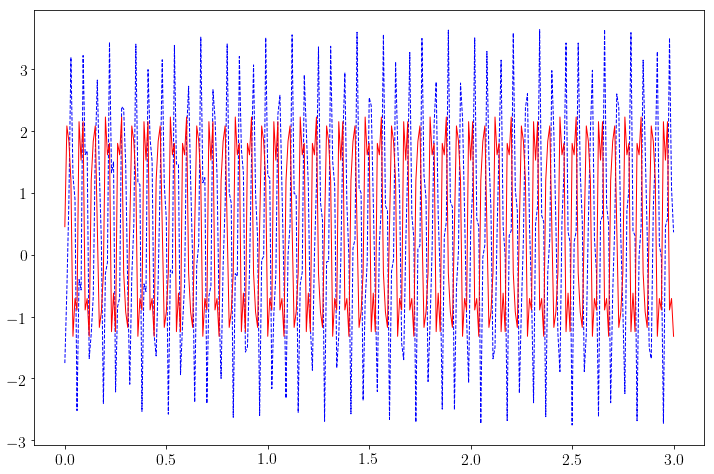

In [21]:
# our model now is the time reconstructed signal
t = arange(0.0,T+del_t,del_t)  # time, t (s)
g1 = DC + a1*sin(2*pi*f1*t) + a2*sin(2*pi*f2*t)
plot(t,g,'b--',t,g1,'r-')